In [76]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

TRAIN_SEASONS = list(range(2019, 2025))
PREDICT_SEASON = 2025
ELO_K = 20
ELO_HOME_ADV = 60
ROLLING_WINDOW = 5
RANDOM_STATE = 42

def init_elo(teams, base=1500):
    return {t: base for t in teams}

def expected_score(elo_ta, elo_th):
    return 1 / (1 + 10 ** ((elo_ta - elo_th) / 400.0))

def compute_elo_ratings(df):
    """
    Compute per-match pre-game ELO ratings for home and away teams.
    Returns two new columns: elo_home_pre, elo_away_pre
    """

    team_col_home='home_team'
    team_col_away='away_team'
    score_home='home_score'
    score_away='away_score'
    season_order_col='kickoff_datetime'

    teams = pd.concat([df[team_col_home], df[team_col_away]]).unique()
    elo = init_elo(teams)
    elo_home_pre = []
    elo_away_pre = []

    df_sorted = df.sort_values(by=season_order_col).reset_index(drop=True)
    for _, row in df_sorted.iterrows():
        th = row[team_col_home]
        ta = row[team_col_away]
        elo_home_pre.append(elo[th])
        elo_away_pre.append(elo[ta])

        # compute outcome
        if row[score_home] > row[score_away]:
            s_h, s_a = 1.0, 0.0
        elif row[score_home] < row[score_away]:
            s_h, s_a = 0.0, 1.0
        else:
            s_h, s_a = 0.5, 0.5

        exp_h = expected_score(elo[ta], elo[th])
        exp_a = 1-exp_h

        elo[th] = elo[th] + ELO_K * (s_h - exp_h)
        elo[ta] = elo[ta] + ELO_K * (s_a - exp_a)

    # attach to original index
    df_out = df_sorted.copy()
    df_out['elo_home_pre'] = elo_home_pre
    df_out['elo_away_pre'] = elo_away_pre
    return df_out.sort_index()  # put back in original order

def predict(df):

    df = df.rename(columns={ 'winner': 'winner_label', 'outcome': 'outcome_label' }) if 'winner' in df.columns else df

    df = compute_elo_ratings(df)

    df['home_adv'] = 1
    df['goal_diff_pre'] = df['elo_home_pre'] - df['elo_away_pre']
    df['kickoff_dayofweek'] = df['kickoff_datetime'].dt.weekday
    df['kickoff_hour'] = df['kickoff_datetime'].dt.hour

    home_rows = df[['match_id','kickoff_datetime','season','home_team','away_team','home_score','away_score']].copy()
    home_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    home_rows['is_home'] = 1
    away_rows = df[['match_id','kickoff_datetime','season','away_team','home_team','away_score','home_score']].copy()
    away_rows.columns = ['match_id','kickoff_datetime','season','team','opponent','score_for','score_against']
    away_rows['is_home'] = 0
    team_rows = pd.concat([home_rows, away_rows], ignore_index=True)

    team_rows = team_rows.sort_values(['team','kickoff_datetime'])
    #compute rolling avg
    team_rows['points'] = team_rows.apply(lambda r: 3 if r['score_for']>r['score_against'] else (1 if r['score_for']==r['score_against'] else 0), axis=1)
    team_rows[['gf_roll','ga_roll','pts_roll']] = team_rows.groupby('team')[['score_for','score_against','points']].rolling(window=ROLLING_WINDOW, min_periods=1).mean().reset_index(level=0, drop=True)[['score_for','score_against','points']]

    # take last pre-match rolling values for home and away
    team_rows = team_rows.sort_values(['match_id','team','kickoff_datetime']).drop_duplicates(subset=['match_id','team'], keep='last')
    home_features = team_rows[team_rows['is_home']==1][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'home_{c}' if c!='match_id' else c)
    away_features = team_rows[team_rows['is_home']==0][['match_id','gf_roll','ga_roll','pts_roll']].rename(columns=lambda c: f'away_{c}' if c!='match_id' else c)
    df = df.merge(home_features, on='match_id', how='left').merge(away_features, on='match_id', how='left')

    df = df.sort_values('kickoff_datetime').reset_index(drop=True)
    h2h_home_wins = []
    h2h_away_wins = []
    h2h_draws = []
    h2h_hist = {}
    for _, row in df.iterrows():
        key = tuple(sorted([row['home_team'], row['away_team']]))
        hist = h2h_hist.get(key, {'home_w':0,'away_w':0,'draw':0,'matches':0})
        h2h_home_wins.append(hist['home_w'])
        h2h_away_wins.append(hist['away_w'])
        h2h_draws.append(hist['draw'])
        # update hist with this match result (home/away relative to original home)
        if row['home_score'] > row['away_score']:
            hist['home_w'] += 1
        elif row['home_score'] < row['away_score']:
            hist['away_w'] += 1
        else:
            hist['draw'] += 1
        hist['matches'] += 1
        h2h_hist[key] = hist
    df['h2h_home_wins_prior'] = h2h_home_wins
    df['h2h_away_wins_prior'] = h2h_away_wins
    df['h2h_draws_prior'] = h2h_draws

    last_kickoff = {}
    rest_days_home = []
    rest_days_away = []
    for _, row in df.iterrows():
        th = row['home_team']; ta = row['away_team']; t0 = row['kickoff_datetime']

        if th in last_kickoff:
            delta = (t0 - last_kickoff[th]).total_seconds() / (24*3600)
            rest_days_home.append(delta)
        else:
            rest_days_home.append(np.nan)
        last_kickoff[th] = t0

        if ta in last_kickoff:
            delta = (t0 - last_kickoff[ta]).total_seconds() / (24*3600)
            rest_days_away.append(delta)
        else:
            rest_days_away.append(np.nan)
        last_kickoff[ta] = t0
    df['rest_days_home'] = rest_days_home
    df['rest_days_away'] = rest_days_away
    df['rest_days_diff'] = df['rest_days_home'] - df['rest_days_away']


    label_map = {'H':0,'D':1,'A':2}
    df['target'] = df['outcome_label'].map(label_map)

    # Test is season 2025
    TRAIN_SEASONS = list(range(df['season'].min(), 2024))
    PREDICT_SEASON = list(range(2024,df['season'].max() +1))
    print(TRAIN_SEASONS, PREDICT_SEASON)
    train_df = df[df['season'].isin(TRAIN_SEASONS)].copy()
    test_df = df[df['season'].isin(PREDICT_SEASON)].copy()


    features = [
        'elo_home_pre','elo_away_pre','goal_diff_pre',
        'matchweek','kickoff_dayofweek','kickoff_hour',
        'home_gf_roll','home_ga_roll','home_pts_roll',
        'away_gf_roll','away_ga_roll','away_pts_roll',
        'h2h_home_wins_prior','h2h_away_wins_prior','h2h_draws_prior',
        'rest_days_home','rest_days_away','rest_days_diff','home_team_id', 'away_team_id'
    ]

    X_train = train_df[features]
    y_train = train_df['target']

    X_test = test_df[features]
    y_test = test_df['target']

    rf_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )

    rf_model.fit(X_train, y_train)
    #Predict with RandomForestClassifier the probability of H, D or A
    prob = rf_model.predict_proba(X_test)
    pred_labels = np.argmax(prob, axis=1)
    test_df[['prob_H','prob_D','prob_A']] = prob
    inv_label = {v:k for k,v in label_map.items()}
    test_df['pred_outcome'] = [inv_label[l] for l in pred_labels]
    def pred_winner(row):
        if row['pred_outcome'] == 'H':
            return row['home_team']
        elif row['pred_outcome'] == 'A':
            return row['away_team']
        else:
            return 'Draw'
    test_df['pred_winner'] = test_df.apply(pred_winner, axis=1)

    #evaluate
    if 'target' in test_df.columns:
        print("Test logloss:", log_loss(y_test, prob))
        print("Test accuracy:", accuracy_score(y_test, pred_labels))
        print("Confusion matrix (rows true, cols pred):")
        print(confusion_matrix(y_test, pred_labels))
    #Save the results to a csv
    out_path = 'predictions_2025_matches.csv'
    test_df.to_csv(out_path, index=False)
    print(f"Predictions saved to {out_path}. Sample:")
    print(test_df[['match_id','kickoff_datetime','home_team','away_team','prob_H','prob_D','prob_A','pred_outcome','pred_winner']].head(10))

    #plot the most important features
    importances = rf_model.feature_importances_
    feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_importance.values, y=feat_importance.index)
    plt.title("Feature Importance")
    plt.show()

In [68]:
import data_loader as dl
import importlib
importlib.reload(dl)
m,s = dl.load_data()
m


✓ Successfully loaded 3509 matches from matchweeks 1-38

Sample data:
   matchweek                 home_team         away_team  home_score  \
0          1                 Liverpool       Bournemouth           4   
1          1               Aston Villa  Newcastle United           0   
2          1  Brighton and Hove Albion            Fulham           1   
3          1         Nottingham Forest         Brentford           3   
4          1                Sunderland   West Ham United           3   

   away_score outcome  
0           2       H  
1           0       D  
2           1       D  
3           1       H  
4           0       H  

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509 entries, 0 to 3508
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   match_id              3509 non-null   object        
 1   matchweek             3509 non-null   int64   

/Users/daniel/PycharmProjects/epl-match-outcome-predictor/data_loader.py:176: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  m['attendance'].fillna(mean_attendance, inplace=True)


,match_id,matchweek,season,kickoff,kickoff_timezone,period,competition,venue,attendance,clock,...,home_red_cards,away_team,away_team_id,away_team_short,away_score,away_half_time_score,away_red_cards,outcome,winner,kickoff_datetime
0,2561895,1,2025,2025-08-15 20:00:00,BST,FullTime,Premier League,"Anfield, Liverpool",60315.0,97,...,0.0,Bournemouth,91,Bournemouth,2,0,0.0,H,Liverpool,2025-08-15 20:00:00
1,2561896,1,2025,2025-08-16 12:30:00,BST,FullTime,Premier League,"Villa Park, Birmingham",42526.0,97,...,1.0,Newcastle United,4,Newcastle,0,0,0.0,D,Draw,2025-08-16 12:30:00
2,2561897,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"American Express Stadium, Falmer",31478.0,98,...,0.0,Fulham,54,Fulham,1,0,0.0,D,Draw,2025-08-16 15:00:00
3,2561898,1,2025,2025-08-17 14:00:00,BST,FullTime,Premier League,"The City Ground, Nottingham",29949.0,96,...,0.0,Brentford,94,Brentford,1,0,0.0,H,Nottingham Forest,2025-08-17 14:00:00
4,2561899,1,2025,2025-08-16 15:00:00,BST,FullTime,Premier League,"Stadium of Light, Sunderland",46233.0,98,...,0.0,West Ham United,21,West Ham,0,0,0.0,H,Sunderland,2025-08-16 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3504,855547,38,2016,2017-05-21 15:00:00,BST,FullTime,Premier League,"Anfield, Liverpool",53191.0,93,...,0.0,Middlesbrough,25,Boro,0,0,0.0,H,Liverpool,2017-05-21 15:00:00
3505,855548,38,2016,2017-05-21 15:00:00,BST,FullTime,Premier League,"Old Trafford, Manchester",75254.0,94,...,0.0,Crystal Palace,31,Crystal Palace,0,0,0.0,H,Manchester United,2017-05-21 15:00:00
3506,855549,38,2016,2017-05-21 15:00:00,BST,FullTime,Premier League,"St. Mary's Stadium, Southampton",31286.0,94,...,0.0,Stoke City,110,Stoke,1,0,0.0,A,Stoke City,2017-05-21 15:00:00
3507,855550,38,2016,2017-05-21 15:00:00,BST,FullTime,Premier League,"Swansea.com Stadium, Swansea",20889.0,95,...,0.0,West Bromwich Albion,35,West Brom,1,1,0.0,H,Swansea City,2017-05-21 15:00:00


[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023] [2024, 2025]
Test logloss: 0.8075981654216746
Test accuracy: 0.6481876332622601
Confusion matrix (rows true, cols pred):
[[174   5  20]
 [ 65  13  34]
 [ 32   9 117]]
Predictions saved to predictions_2025_matches.csv. Sample:
     match_id    kickoff_datetime          home_team  \
3040  2444470 2024-08-16 20:00:00  Manchester United   
3041  2444473 2024-08-17 12:30:00       Ipswich Town   
3042  2444474 2024-08-17 15:00:00   Newcastle United   
3043  2444475 2024-08-17 15:00:00  Nottingham Forest   
3044  2444472 2024-08-17 15:00:00            Everton   
3045  2444471 2024-08-17 15:00:00            Arsenal   
3046  2444476 2024-08-17 17:30:00    West Ham United   
3047  2444477 2024-08-18 14:00:00          Brentford   
3048  2444478 2024-08-18 16:30:00            Chelsea   
3049  2444479 2024-08-19 20:00:00     Leicester City   

                     away_team  prob_H  prob_D  prob_A pred_outcome  \
3040                    Fulham   0.59

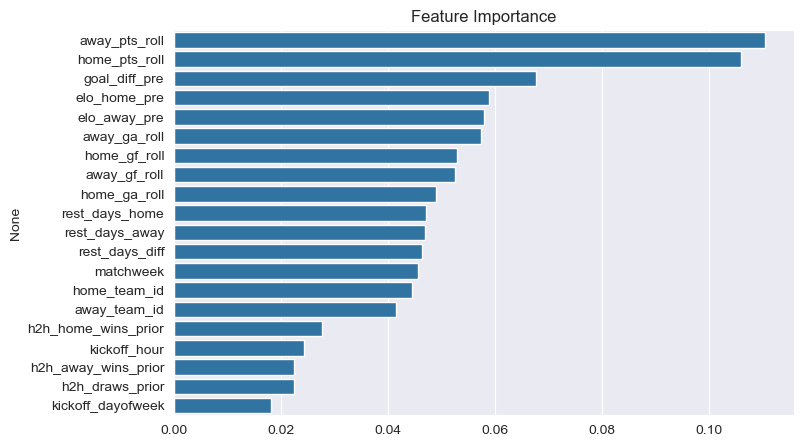

In [77]:
predict(m)